In [1]:
import pandas
import math
chiller1 = pandas.read_csv('Chiller1.csv', parse_dates = ['Time'], index_col = 'Time', dayfirst = True) 
chiller2 = pandas.read_csv('Chiller2.csv', parse_dates = ['Time'], index_col = 'Time', dayfirst = True)

In [2]:
chiller1['kWH'] = chiller1.kWE * 5 / 60
chiller2['kWH'] = chiller2.kWE * 5 / 60
MWH1 = chiller1['kWH'].sum() / 1000
MWH2 = chiller2['kWH'].sum() / 1000
print('Total MWH for Chiller 1 =', MWH1,'MWH')
print('Total MWH for Chiller 2 =', MWH2,'MWH')
print('Total MWH for both Chillers =', MWH1 + MWH2,'MWH')

Total MWH for Chiller 1 = 38.732087506680664 MWH
Total MWH for Chiller 2 = 21.564999372362916 MWH
Total MWH for both Chillers = 60.297086879043576 MWH


In [3]:
TempDiff1 = abs(chiller1.EnterTemp - chiller1.LeaveTemp)
chiller1['kWR'] = chiller1.Flow * 4.19 * TempDiff1
chiller1['COP'] = chiller1.kWR/chiller1.kWE
chiller1_on = chiller1[chiller1.kWE > 0]

In [4]:
TempDiff2 = abs(chiller2.EnterTemp - chiller2.LeaveTemp)
chiller2['kWR'] = chiller2.Flow * 4.19 * TempDiff2
chiller2['COP'] = chiller2.kWR/chiller2.kWE
chiller2_on = chiller2[chiller2.kWE > 0]

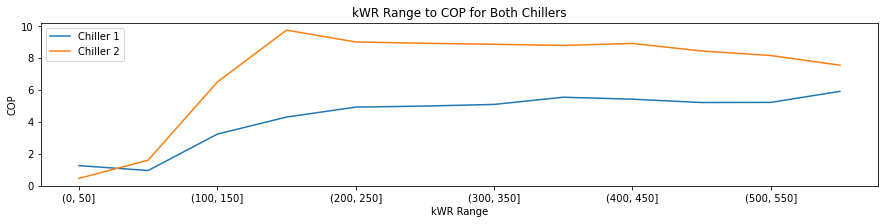

In [5]:
kWR_bin1 = chiller1_on.groupby(pandas.cut(chiller1_on.kWR, range(0,650,50))).mean().COP.to_frame()
kWR_bin1.COP.plot(figsize=(15, 3))
kWR_bin2 = chiller2_on.groupby(pandas.cut(chiller2_on.kWR, range(0,650,50))).mean().COP.to_frame()
bin_plot = kWR_bin2.COP.plot(figsize=(15, 3),  title='kWR Range to COP for Both Chillers', xlabel ='kWR Range', ylabel = 'COP', )
bin_plot.legend(["Chiller 1", "Chiller 2"]);

In [6]:
def kWE_estimate1(Flow,TempDiff) :
    if Flow < 12 :
        Flow = 12
    kWR = Flow * 4.19 * (TempDiff)
    if kWR <= 0 :
        kWE = 0
    else :
        if kWR > 600 or Flow > 23 :
            kWE = math.inf
        else :
            COP = kWR_bin1.loc[kWR]['COP']
            kWE = kWR/COP
    return kWE


def kWE_estimate2(Flow,TempDiff) :
    if Flow < 12 :
        Flow = 12
    kWR = Flow * 4.19 * (TempDiff)
    if kWR <= 0:
        kWE = 0
    else :
        if kWR > 600 or Flow > 23 :
            kWE = math.inf
        else :
            COP = kWR_bin2.loc[kWR]['COP']
            kWE = kWR/COP
    return kWE

In [7]:
kWE_estimate1_apply = chiller1_on.apply(
         lambda row: kWE_estimate1(row['Flow'], abs(row['EnterTemp'] - row['LeaveTemp'])),
         axis=1)
chiller1['Estimate kWE'] = kWE_estimate1_apply

In [8]:
kWE_estimate2_apply = chiller2_on.apply(
         lambda row: kWE_estimate2(row['Flow'], abs(row['EnterTemp'] - row['LeaveTemp'])),
         axis=1)
chiller2['Estimate kWE'] = kWE_estimate2_apply

In [9]:
chiller1['kWH'] = chiller1['Estimate kWE'] * 5 / 60
chiller2['kWH'] = chiller2['Estimate kWE'] * 5 / 60

Estimate_MWH1 = chiller1['kWH'].sum() / 1000
Estimate_MWH2 = chiller2['kWH'].sum() / 1000
print('Estimate Total MWH for Chiller 1 =', Estimate_MWH1,'MWH')
print('Estimate Total MWH for Chiller 2 =', Estimate_MWH2,'MWH')
print('Estimate Total MWH for both Chillers =', Estimate_MWH1 + Estimate_MWH2,'MWH')

Estimate Total MWH for Chiller 1 = 37.30459266351502 MWH
Estimate Total MWH for Chiller 2 = 21.290319693127866 MWH
Estimate Total MWH for both Chillers = 58.59491235664288 MWH


The Estimate MWH Totals for each chiller and both align with the results above, varying by approximately 2MWH. Thus this model is mdoerately accurate at predicting the MWH usage reasonably.

In [10]:
common = pandas.read_csv('Common.csv', parse_dates = ['Time'], index_col = 'Time', dayfirst = True) 

In [11]:
def optimal_kWE(Flow,TempDiff) :   
    chiller1only = kWE_estimate1(Flow, TempDiff)
    chiller2only = kWE_estimate2(Flow, TempDiff)    
    current_flow = Flow
    for a in range(0, round(Flow), 1) :
        current_estimate = kWE_estimate1(a,TempDiff) + kWE_estimate2(Flow - a,TempDiff)
        optimal_estimate = kWE_estimate1(current_flow,TempDiff) + kWE_estimate2(Flow - current_flow,TempDiff)
        if current_estimate < optimal_estimate :
            current_flow = a
    return min(optimal_estimate, chiller1only, chiller2only)

In [12]:
optimal_kWE_apply = common.apply(
         lambda row: optimal_kWE(row['Flow'], abs(row['EnterTemp'] - row['LeaveTemp'])),
         axis=1)
common['Total Estimate kWE'] = optimal_kWE_apply

In [13]:
common['kWH'] = common['Total Estimate kWE'] * 5 / 60
MWH = common['kWH'].sum() / 1000
print('Total Estimated MWH using alternative stepping algorithm =', MWH,'MWH')

Total Estimated MWH using alternative stepping algorithm = 54.03765137420557 MWH


The Estimated MWH using the alternative stepping algorithm has a lower MWH compared to the actual 60.297MWH calculated above. If the Alternative stepping algorithm was used, then costs would have been saved. However, this algorithm is still not feasible in practise due to assuming that the common supply temperature is the actual temperature in the chillers. Furthermore, this algorithm rounds flow and steps in 1, not considering all possibilities for flow.